In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [16]:
data = pd.read_hdf('Figure2.h5', key='data')

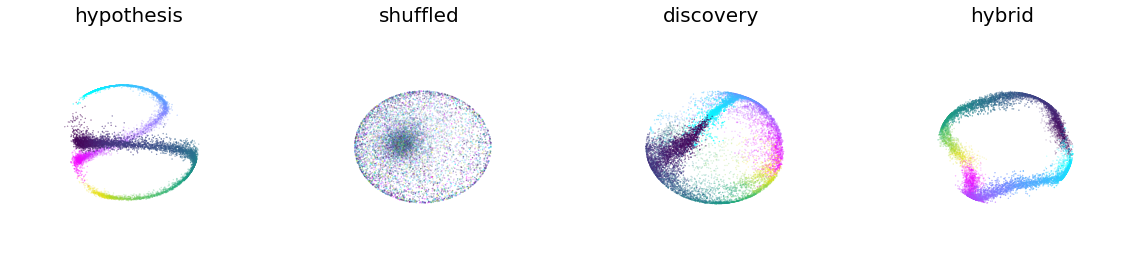

In [31]:
method_viz = data['visualization']

fig=plt.figure(figsize=(20,5))
for i,model in enumerate(['hypothesis', 'shuffled', 'discovery', 'hybrid']):
    ax = fig.add_subplot(1,4, i+1, projection = '3d')
    emb=method_viz[model]['embedding']
    label = method_viz[model]['label']
    r = label[:,1]==1
    l = label[:,2]==1
    idx1,idx2,idx3 = (0,1,2)
    if i== 3:
        idx1,idx2,idx3 = (1,2,0)
    ax.scatter(emb[l,idx1], emb[l,idx2], emb[l,idx3], c=label[l,0], cmap='cool', s=0.1)
    ax.scatter(emb[r,idx1], emb[r,idx2], emb[r,idx3], c=label[r,0],  s=0.1)
    ax.axis('off')
    ax.set_title(f'{model}', fontsize=20)

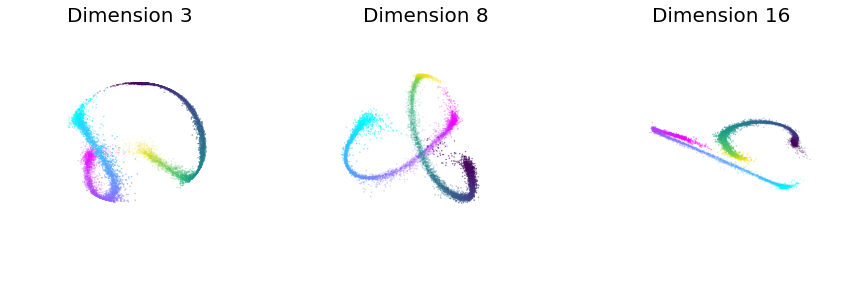

In [38]:
topology_viz = data['topology']['viz']

fig=plt.figure(figsize=(15,5))
for i,dim in enumerate([3,8,16]):
    ax = fig.add_subplot(1,3, i+1, projection = '3d')
    emb=topology_viz[dim]
    label = topology_viz['label']
    r = label[:,1]==1
    l = label[:,2]==1
    idx1,idx2,idx3 = (0,1,2)
    if i== 1:
        idx1,idx2,idx3 = (5,6,7)
    ax.scatter(emb[l,idx1], emb[l,idx2], emb[l,idx3], c=label[l,0], cmap='cool', s=0.1)
    ax.scatter(emb[r,idx1], emb[r,idx2], emb[r,idx3], c=label[r,0],  s=0.1)
    ax.axis('off')
    ax.set_title(f'Dimension {dim}', fontsize=20)

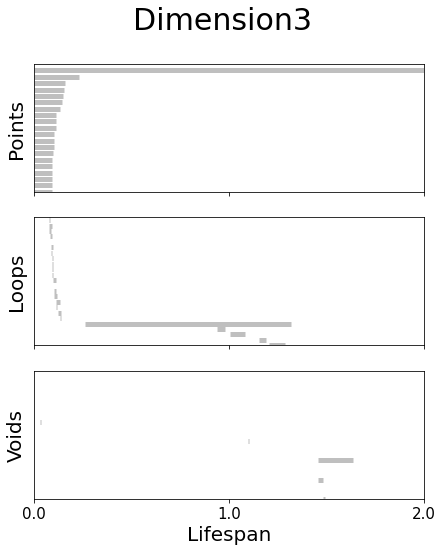

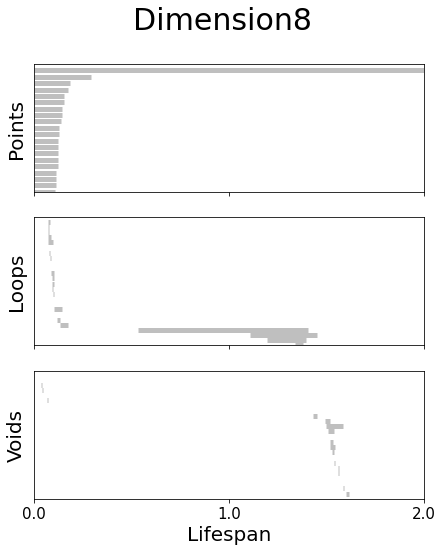

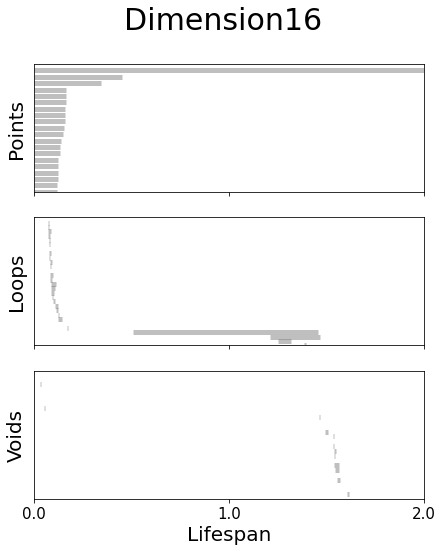

In [7]:
dims=[3,8,16]
cocycle=['Points', 'Loops', 'Voids']
colors =['b', 'orange', 'green']
for d in range(3):
    topology_result=behavior_topology[dims[d]]['dgms']#analysis_offsets[d]['dgms']
    fig, axs = plt.subplots(3,1,sharex=True, figsize=(7,8))
    fig.suptitle(f'Dimension{dims[d]}', fontsize=30)
    axs[0].set_xlim(0,2)
    
    for k in range(3):
        bars = topology_result[k]
        bars[bars == np.inf] = 10
        lc=np.vstack([bars[:,0], np.arange(len(bars), dtype =int)*6, bars[:,1] , np.arange(len(bars), dtype =int)*6 ]).swapaxes(1,0).reshape(-1,2,2)
        line_segments = LineCollection(lc, linewidth= 5, color='gray', alpha = 0.5)
        axs[k].set_ylabel(cocycle[k], fontsize=20)
        if k==0:
            axs[k].set_ylim(len(bars)*6-120,len(bars)*6)
        elif k==1:
            axs[k].set_ylim(0,len(bars)*1-30)
        elif k ==2:
            axs[k].set_ylim(0,len(bars)*6+10)
        axs[k].add_collection(line_segments)
        axs[k].set_yticks([])
        if k==2:
            axs[k].set_xticks(np.linspace(0,2,3), np.linspace(0,2,3),fontsize=15)
            axs[k].set_xlabel('Lifespan', fontsize=20)